# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for AdvXResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
import pdb

In [4]:
__version__

'1.0.56.dev0'

# 6D image test

In [5]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [6]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [7]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [8]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [9]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset parameters full dataset

In [10]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v1_20190714.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v1_20190714.csv', index_col=0)

In [11]:
df_train.head()

,path,experiment,sirna,multi,valid
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513,0
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840,0
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020,0
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254,0
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144,0


In [12]:
df_test.head()

,path,experiment
0,HEPG2-08/Plate1/B03_s1,HEPG2-08
1,HEPG2-08/Plate1/B04_s1,HEPG2-08
2,HEPG2-08/Plate1/B05_s1,HEPG2-08
3,HEPG2-08/Plate1/B06_s1,HEPG2-08
4,HEPG2-08/Plate1/B07_s1,HEPG2-08


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [13]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [14]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [15]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [16]:
## ResNet50pt
#sz, bs = 96, 8*46 # 77560MiB /  7952MiB

## XResNet50c
#sz, bs = 96, 8*46 # 7573MiB /  7952MiB
#sz, bs = 128, 8*52 # 7935MiB /  7952MiB
#sz, bs = 256, 8*13 # 7929MiB /  7952MiB
sz, bs = 512, 8*3 # 7575MiB /  7952MiB

In [17]:
sz, bs

(512, 24)

In [18]:
# normal tfms
#tfms = get_transforms()

# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=color_augmentation())

In [19]:
# future transform mix?

### Full dataset

In [20]:
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [21]:
data

ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: EmptyLabelList
,,,,
Path: train

In [22]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [23]:
data.train_ds[0]

(Image6D (6, 512, 512), Category 513)

In [24]:
#data.classes

In [25]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

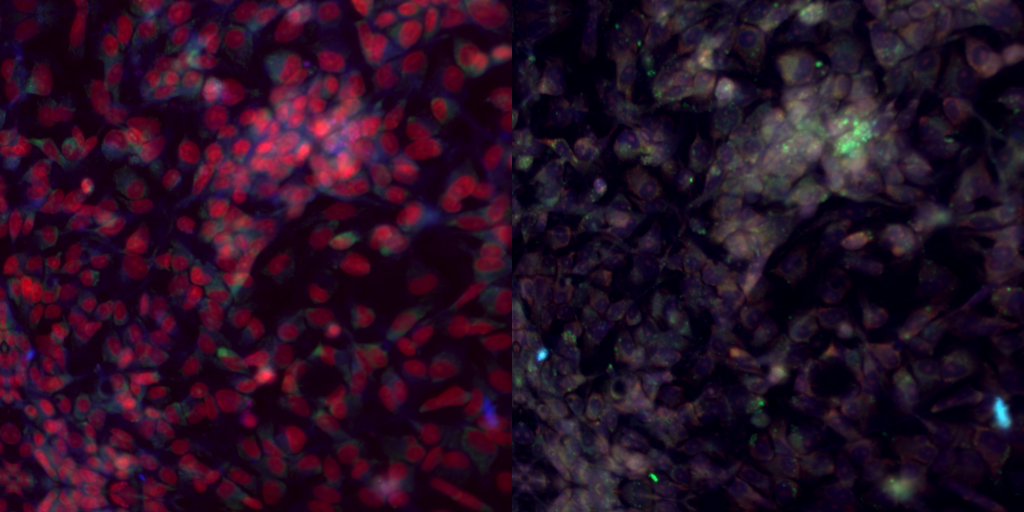

In [26]:
data.train_ds[0][0]

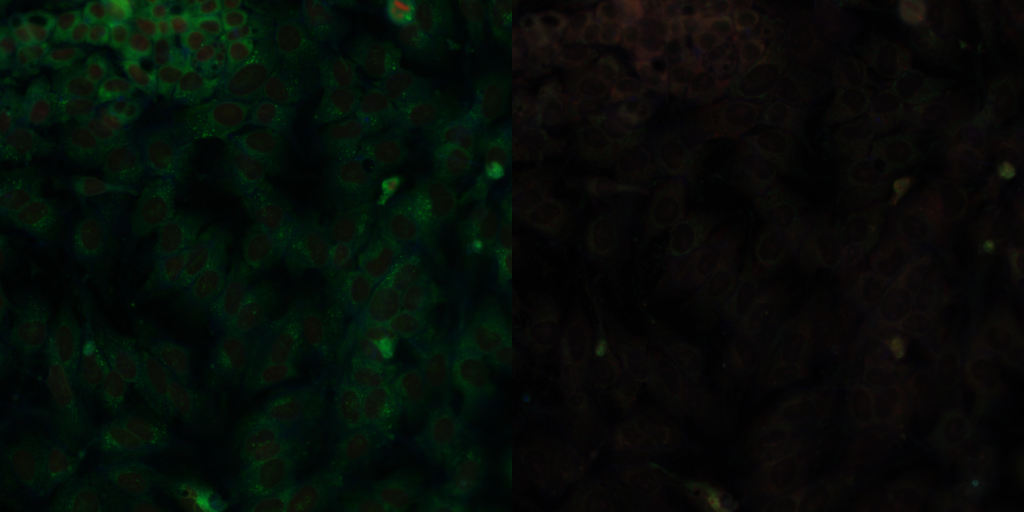

In [27]:
data.test_ds[0][0]

### Adversarial full dataset

In [281]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [282]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [283]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [284]:
data_a.batch_size

208

In [285]:
data_a.train_ds[0]

(Image6D (6, 128, 128), MultiCategory HEPG2-01;513)

In [286]:
#data_a.classes

In [287]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

(MultiCategory HEPG2-01;513,
 array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32))

In [288]:
data_a.train_ds[0][1].data.sum()

2.0

In [289]:
np.where(data_a.train_ds[0][1].data > 0.5)

(array([ 569, 1108]),)

In [290]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

['513', 'HEPG2-01']

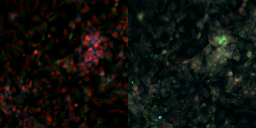

In [291]:
data_a.train_ds[0][0]

In [292]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## ResNet50 pretrained

In [84]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [85]:
# gives an error, because expects 6-channel weight in first conv layer
#learn.summary()

In [86]:
#learn.model

In [87]:
learn.model[0][0], type(learn.model[0][0])

(Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 torch.nn.modules.conv.Conv2d)

In [88]:
torch.nn.modules.conv.Conv2d is nn.Conv2d

True

In [89]:
p_dict = {pn: p for pn, p in learn.model[0][0].named_parameters()}

In [90]:
p_dict['weight'].shape, p_dict['weight'].requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [91]:
old_weight = p_dict['weight'].detach()

In [92]:
old_weight.shape, old_weight.requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [93]:
new_weight = torch.cat((old_weight, old_weight), dim=1)

In [94]:
new_weight.shape, new_weight.requires_grad

(torch.Size([64, 6, 7, 7]), False)

In [95]:
# replace first conv layer with a 6-channel version
learn.model[0][0] = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [96]:
learn.model[0][0]

Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [97]:
learn.model[0][0].weight.shape

torch.Size([64, 6, 7, 7])

In [98]:
# set new_weights to nn.Parameter and overwrite it in the conv layer
learn.model[0][0].weight = nn.Parameter(new_weight) # hand over requires_grad False?

In [99]:
# check if weight was loaded properly
assert torch.allclose(new_weight, learn.model[0][0].weight)

In [100]:
learn.model[0][0].weight.shape, learn.model[0][0].weight.requires_grad

(torch.Size([64, 6, 7, 7]), True)

In [101]:
# freeze input stage to only train output stage
#learn.freeze()
# DOES NOT WORK FOR INPUT CONV LAYER?

In [102]:
learn.model[0][0].weight.requires_grad = False

In [103]:
# check if layer is trainable and model looks fine
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 48, 48]         18,816     False     
______________________________________________________________________
BatchNorm2d          [64, 48, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 48, 48]         0          False     
______________________________________________________________________
MaxPool2d            [64, 24, 24]         0          False     
______________________________________________________________________
Conv2d               [64, 24, 24]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
Conv2d               [64, 24, 24]         36,864     False     
___________________________________________________

In [104]:
learn.model(torch.randn(1,6,sz,sz).cuda()).shape

torch.Size([1, 1108])

In [105]:
learn.model(data.train_ds[0][0].data.unsqueeze(0).cuda()).shape

torch.Size([1, 1108])

## XResNet50

In [28]:
xresnet50c = XResNet(4, [3,4,6 ,3], c_in=6, c_out=1108)

In [29]:
#xresnet50c

In [30]:
xresnet50c(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 1108])

In [31]:
xresnet50c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

## AdvXResNet50

In [25]:
class AdvXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            #nn.Linear(block_szs[-1]*expansion, c_out),
            output_a(block_szs, expansion, c_out, c_out_a)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [26]:
# https://github.com/janfreyberg/pytorch-revgrad v0.1
from torch.autograd import Function

class RevGrad(Function):
    @staticmethod
    def forward(ctx, input_):
        ctx.save_for_backward(input_)
        output = input_
        return output

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        grad_input = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output * ifnone(learn_a.opt.gr,0) # Gradient reversal !!!
            #print(learn_a.opt.gr)
        return grad_input


revgrad = RevGrad.apply

class RevGrad(Module):
    def __init__(self, *args, **kwargs):
        """
        A gradient reversal layer.
        This layer has no parameters, and simply reverses the gradient
        in the backward pass.
        """

        super().__init__(*args, **kwargs)

    def forward(self, input_):
        return revgrad(input_)

In [27]:
class output_a(Module):
    def __init__(self, block_szs, expansion, c_out, c_out_a):
        self.c_out, self.c_out_a = c_out, c_out_a
        
        self.AAP = nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.lin_label1 = nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion)
        self.lin_label2 = nn.Linear(block_szs[-1]*expansion, c_out)
        
        self.lin_domain1 = nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion)
        self.lin_domain2 = nn.Linear(block_szs[-1]*expansion, c_out_a)
        
        self.rg = RevGrad()
        
    def forward(self, x):
        x = self.AAP(x)
        x = self.flatten(x)
        
        x1 = self.lin_label2(act_fn(self.lin_label1(x)))
        x2 = self.lin_domain2(act_fn(self.rg(self.lin_domain1(x))))
        
        return torch.cat((x1, x2), dim=1)

In [28]:
advxresnet50c = AdvXResNet(4, [3,4,6 ,3], c_out_a=data_a.c-1108)

In [29]:
#advxresnet50c

In [30]:
advxresnet50c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1138])

In [31]:
advxresnet50c(data_a.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1138])

# Full training

## Training pretrained ResNet50

In [106]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### 96px normal tfms+CA

#### Unfrozen input stage

In [ ]:
### DO NOT RUN!!!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 1.74E-02


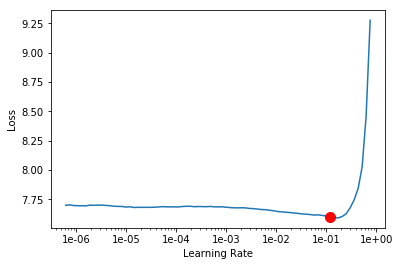

In [56]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [57]:
#learn.fit_one_cycle(4, max_lr=1e-1) # 1e-2 !!

epoch,train_loss,valid_loss,accuracy,time
0,7.383698,7.485749,0.001938,02:35
1,7.680211,7.333767,0.000775,02:37
2,7.349426,6.984512,0.001938,02:40
3,6.982957,6.823052,0.002843,02:41


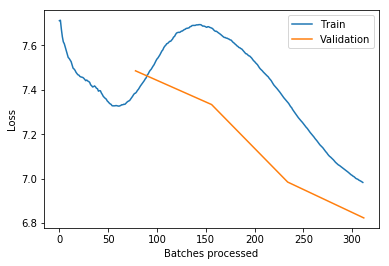

In [58]:
#learn.recorder.plot_losses()

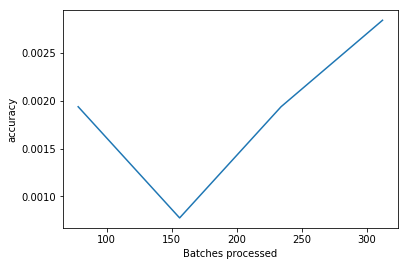

In [59]:
#learn.recorder.plot_metrics()

In [91]:
#learn.recorder.plot_lr(show_moms=True)

#### Frozen input stage

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.45E-02


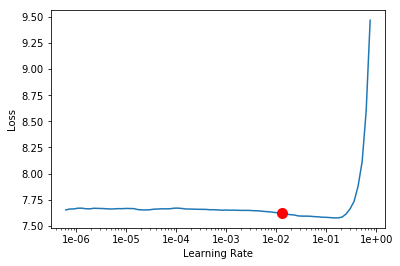

In [107]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [108]:
learn.fit_one_cycle(4, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,7.354742,8.501705,0.001292,02:37
1,7.618409,7.230949,0.001551,02:42
2,7.320005,6.944369,0.002068,02:40
3,6.983054,6.840652,0.002843,02:40


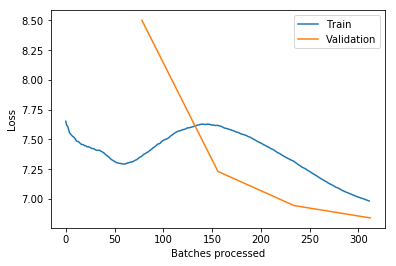

In [109]:
learn.recorder.plot_losses()

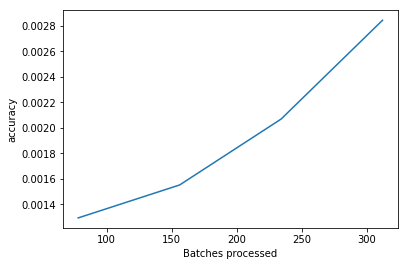

In [110]:
learn.recorder.plot_metrics()

In [111]:
#learn.recorder.plot_lr(show_moms=True)

In [113]:
learn.save('resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e004_20190714', return_path=True)

PosixPath('train/models/resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e004_20190714.pth')

In [114]:
learn.load('resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e004_20190714');

In [115]:
learn.unfreeze() # DOES NOT WORK FOR INPUT CONV LAYER?

In [116]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 48, 48]         18,816     False     
______________________________________________________________________
BatchNorm2d          [64, 48, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 48, 48]         0          False     
______________________________________________________________________
MaxPool2d            [64, 24, 24]         0          False     
______________________________________________________________________
Conv2d               [64, 24, 24]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
Conv2d               [64, 24, 24]         36,864     True      
___________________________________________________

In [117]:
learn.model[0][0].weight.requires_grad = True # MUST BE MANUALLY SET?

In [118]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 48, 48]         18,816     True      
______________________________________________________________________
BatchNorm2d          [64, 48, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 48, 48]         0          False     
______________________________________________________________________
MaxPool2d            [64, 24, 24]         0          False     
______________________________________________________________________
Conv2d               [64, 24, 24]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
Conv2d               [64, 24, 24]         36,864     True      
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 9.12E-06


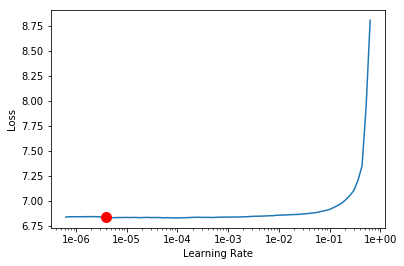

In [119]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [120]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,6.817293,6.813005,0.003231,02:41
1,6.832273,6.840912,0.001809,02:42
2,6.839406,6.899837,0.002843,02:41
3,6.817746,6.819958,0.002843,02:41
4,6.776206,6.785306,0.003489,02:41
5,6.731796,6.757340,0.003231,02:41
6,6.687281,6.751183,0.003360,02:41
7,6.652489,6.746553,0.003102,02:42


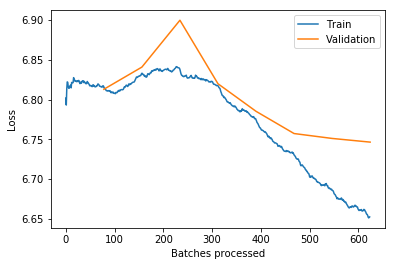

In [121]:
learn.recorder.plot_losses()

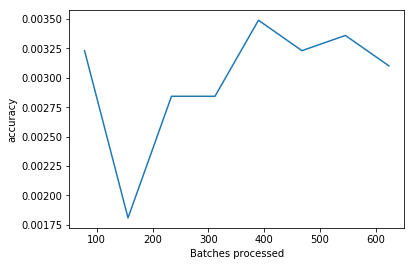

In [122]:
learn.recorder.plot_metrics()

In [123]:
learn.save('resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e012_20190714', return_path=True)

PosixPath('train/models/resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e012_20190714.pth')

In [124]:
learn.load('resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e012_20190714');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 2.29E-07


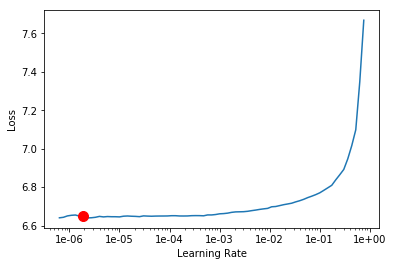

In [125]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [126]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,6.651853,6.756002,0.004523,02:41
1,6.711218,10.422549,0.003748,02:41
2,6.737019,6.783019,0.004135,02:41
3,6.722337,6.797242,0.002455,02:41
4,6.678665,6.749542,0.003877,02:41
5,6.622153,6.740130,0.004394,02:41
6,6.579959,6.727509,0.004006,02:42
7,6.540854,6.723611,0.004911,02:41


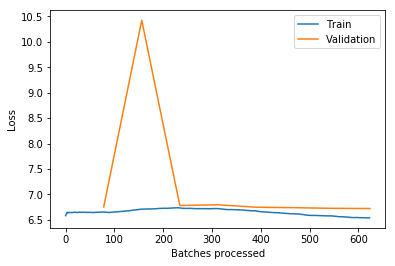

In [127]:
learn.recorder.plot_losses()

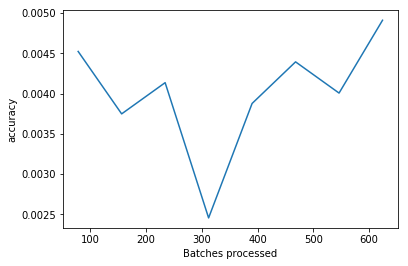

In [128]:
learn.recorder.plot_metrics()

In [129]:
learn.save('resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e020_20190714', return_path=True)

PosixPath('train/models/resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e020_20190714.pth')

In [130]:
learn.load('resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e020_20190714');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


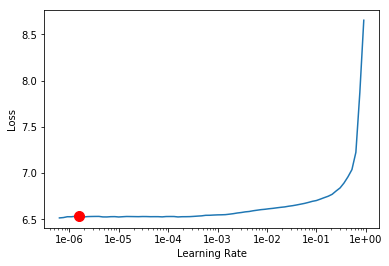

In [131]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [132]:
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,6.525651,6.719964,0.004135,02:41
1,6.538179,6.719161,0.004523,02:41
2,6.556491,6.733480,0.004911,02:41
3,6.588596,6.791404,0.003748,02:41
4,6.609973,6.768948,0.004265,02:41
5,6.602846,6.807866,0.004135,02:41
6,6.596131,6.754138,0.004782,02:41
7,6.571508,6.731497,0.004652,02:41
8,6.537588,6.723186,0.004006,02:41
9,6.516257,6.720225,0.005299,02:41


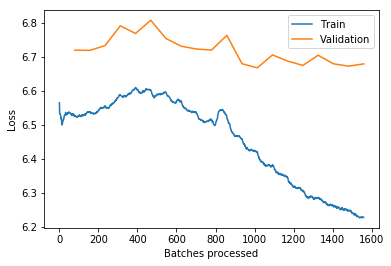

In [133]:
learn.recorder.plot_losses()

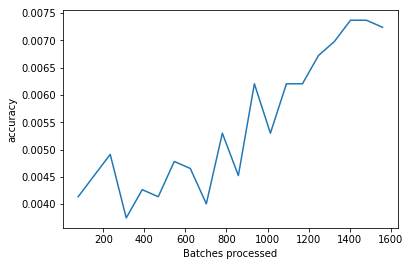

In [134]:
learn.recorder.plot_metrics()

In [135]:
learn.save('resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e040_20190714', return_path=True)

PosixPath('train/models/resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e040_20190714.pth')

In [136]:
learn.load('resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e040_20190714');

In [ ]:
### NOT YET RUN!

In [149]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


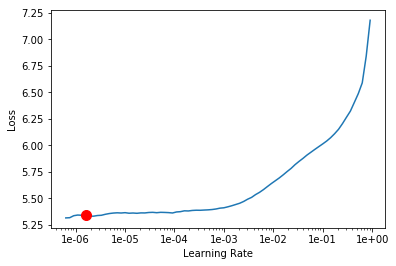

In [144]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [150]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=2)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='???_best')

In [ ]:
learn.fit(350, lr=slice(1e-6,1e-4), callbacks=[redlr, savem])

epoch,train_loss,valid_loss,accuracy,time
0,5.364170,8.816269,0.003610,02:39
1,5.343816,8.783677,0.004212,02:40
2,5.325804,8.780542,0.003911,02:40
3,5.310877,8.851873,0.004212,02:40
4,5.289160,8.962605,0.004212,02:40
5,5.269446,9.000143,0.004212,02:40
6,5.255904,9.272686,0.003911,02:40
7,5.221753,9.053523,0.003911,02:39
8,5.195655,9.192604,0.003008,02:40
9,5.159890,9.183487,0.002708,02:39


Better model found at epoch 0 with accuracy value: 0.003610108280554414.
Better model found at epoch 1 with accuracy value: 0.004211793188005686.
Epoch 5: reducing lr to 1.9999999999999998e-05
Epoch 8: reducing lr to 4e-06
Epoch 11: reducing lr to 8e-07
Epoch 14: reducing lr to 1.6e-07
Epoch 17: reducing lr to 3.2e-08
Epoch 20: reducing lr to 6.400000000000001e-09
Epoch 23: reducing lr to 1.2800000000000003e-09
Epoch 26: reducing lr to 2.560000000000001e-10
Epoch 29: reducing lr to 5.120000000000002e-11
Epoch 32: reducing lr to 1.0240000000000005e-11


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 110: reducing lr to 6.871947673600014e-30
Epoch 113: reducing lr to 1.3743895347200028e-30
Epoch 116: reducing lr to 2.748779069440006e-31
Epoch 119: reducing lr to 5.497558138880011e-32


## Training XResNet50

In [32]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [33]:
# #FP32
#learn = Learner(data, xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger])

## FP16
#learn = Learner(data, xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16()

## FP16 + MixUp
learn = Learner(data, xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16().mixup()

In [34]:
#redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss',patience = 2)
#savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                          name='??_best')

In [ ]:
#leanr.callback # ???

In [29]:
#learn.summary()

In [30]:
#learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### 96px extended tfms+CA

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 1.00E-04


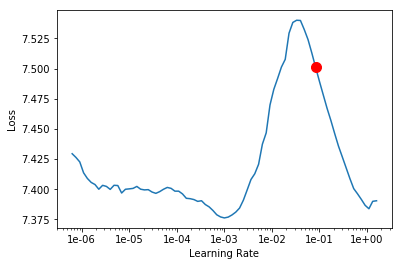

In [33]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.310232,7.026196,0.001809,02:44
1,7.121833,6.906045,0.001938,02:45
2,6.919921,6.809080,0.003231,02:46
3,6.773726,6.798611,0.002455,02:43


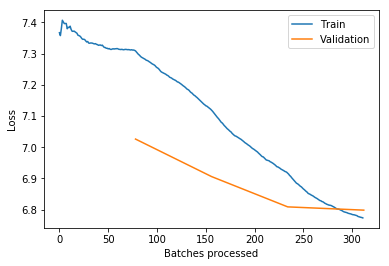

In [36]:
learn.recorder.plot_losses()

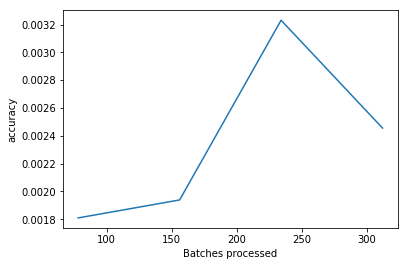

In [37]:
learn.recorder.plot_metrics()

In [38]:
#learn.recorder.plot_lr(show_moms=True)

In [39]:
learn.save('xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e004_20190714', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e004_20190714.pth')

In [40]:
learn.load('xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e004_20190714');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.91E-07


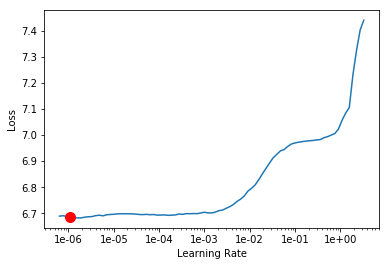

In [41]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [42]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.706491,6.798986,0.003748,02:40
1,6.761999,6.821240,0.001680,02:43
2,6.745856,6.854596,0.003360,02:43
3,6.670441,6.739523,0.004265,02:42
4,6.565350,6.775447,0.004265,02:43
5,6.432373,6.749534,0.005945,02:42
6,6.290907,6.710396,0.007237,02:42
7,6.178641,6.765918,0.006849,02:43


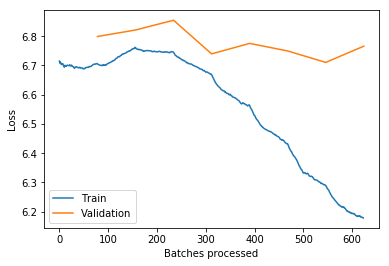

In [43]:
learn.recorder.plot_losses()

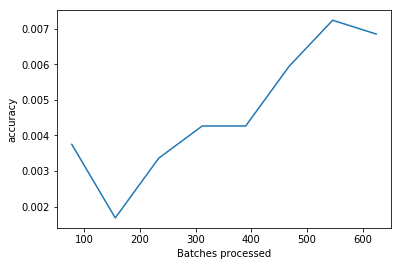

In [44]:
learn.recorder.plot_metrics()

In [45]:
learn.save('xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e012_20190714', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e012_20190714.pth')

In [46]:
learn.load('xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e012_20190714');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.31E-08


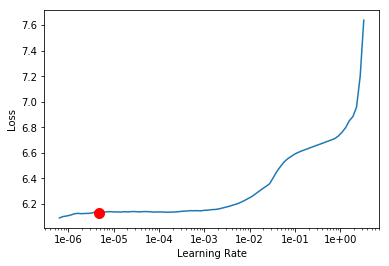

In [47]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [48]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.172524,6.810210,0.005815,02:40
1,6.270131,6.620673,0.007625,02:43
2,6.272264,6.604128,0.007237,02:43
3,6.189271,6.519678,0.009822,02:43
4,6.060186,6.467477,0.013957,02:43
5,5.880962,6.354219,0.014345,02:43
6,5.696725,6.398074,0.017576,02:43
7,5.541817,6.428269,0.017705,02:43


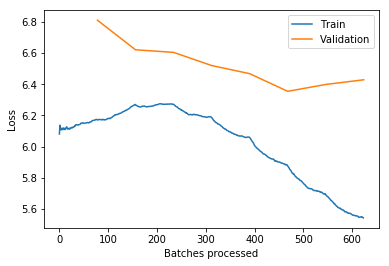

In [49]:
learn.recorder.plot_losses()

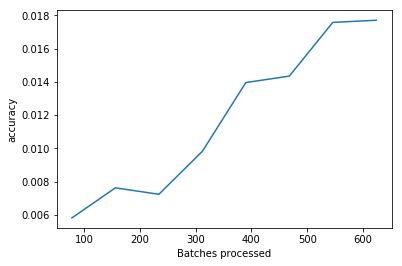

In [50]:
learn.recorder.plot_metrics()

In [51]:
learn.save('xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e020_20190714', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e020_20190714.pth')

In [31]:
learn.load('xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e020_20190714');

#### not yet run!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


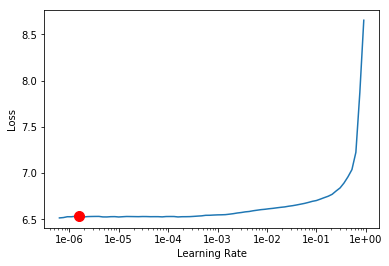

In [131]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [132]:
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,6.525651,6.719964,0.004135,02:41
1,6.538179,6.719161,0.004523,02:41
2,6.556491,6.733480,0.004911,02:41
3,6.588596,6.791404,0.003748,02:41
4,6.609973,6.768948,0.004265,02:41
5,6.602846,6.807866,0.004135,02:41
6,6.596131,6.754138,0.004782,02:41
7,6.571508,6.731497,0.004652,02:41
8,6.537588,6.723186,0.004006,02:41
9,6.516257,6.720225,0.005299,02:41


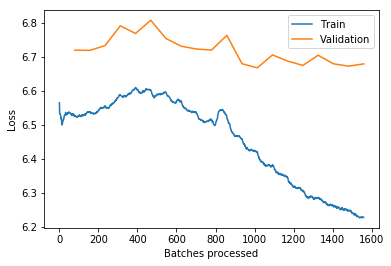

In [133]:
learn.recorder.plot_losses()

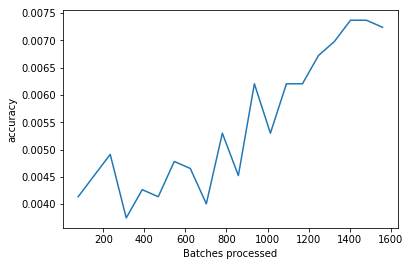

In [134]:
learn.recorder.plot_metrics()

In [135]:
learn.save('xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e040_20190714', return_path=True)

PosixPath('train/models/resnet50pt_valid-split-ex-v1_96px_tfms_colaug_e040_20190714.pth')

In [136]:
learn.load('xresnet50c_valid-split-ex-v1_96px_tfms_colaug_e040_20190714');

### 128px extended tfms+CA

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.92E-05


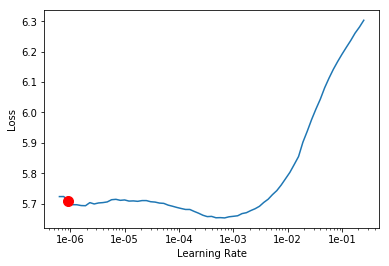

In [32]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [33]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.671397,6.438931,0.015120,02:51
1,5.738825,6.360675,0.014991,02:53
2,5.568907,6.248747,0.022486,02:53
3,5.294126,6.218792,0.023133,02:53


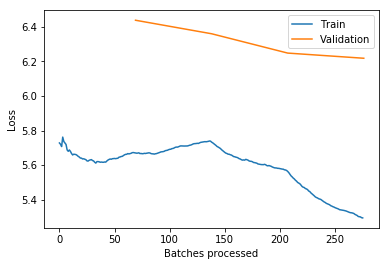

In [34]:
learn.recorder.plot_losses()

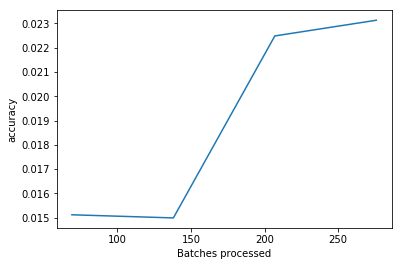

In [35]:
learn.recorder.plot_metrics()

In [36]:
#learn.recorder.plot_lr(show_moms=True)

In [37]:
learn.save('xresnet50c_valid-split-ex-v1_128px_tfms_ca_fp16_e004_20190714', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_128px_tfms_ca_fp16_mu_e004_20190714.pth')

In [38]:
learn.load('xresnet50c_valid-split-ex-v1_128px_tfms_ca_fp16_e004_20190714');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.75E-05


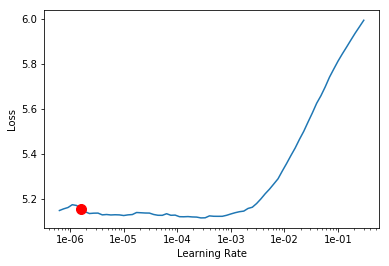

In [39]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.177643,6.302829,0.023520,02:51
1,5.325593,6.296360,0.019902,02:53
2,5.376259,6.403090,0.019514,02:53
3,5.267441,6.369939,0.021323,02:53
4,5.090008,6.167966,0.030887,02:53
5,4.864250,5.948009,0.043810,02:53
6,4.616010,5.927014,0.046394,02:53
7,4.431425,5.930809,0.045877,02:53


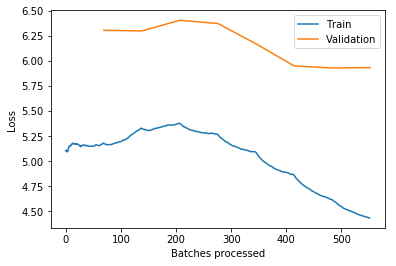

In [42]:
learn.recorder.plot_losses()

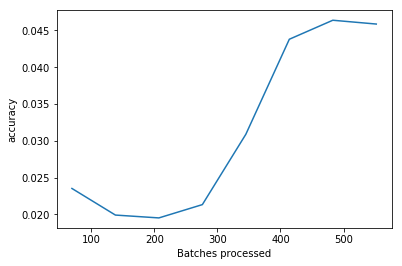

In [43]:
learn.recorder.plot_metrics()

In [44]:
learn.save('xresnet50c_valid-split-ex-v1_128px_tfms_ca_fp16_e012_20190714', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_128px_tfms_ca_fp16_e012_20190714.pth')

In [36]:
learn.load('xresnet50c_valid-split-ex-v1_128px_tfms_ca_fp16_e012_20190714');

### 256px extended tfms+CA switch to FP16 and mixup

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 1.45E-04


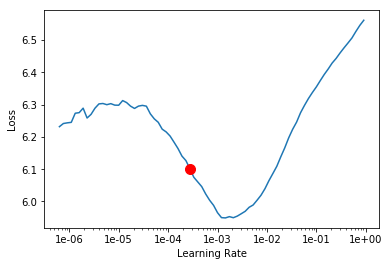

In [37]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,5.084296,5.950623,0.034247,03:31
1,4.839947,5.899736,0.042259,03:32
2,4.705284,5.800541,0.045877,03:32
3,4.552098,5.788888,0.048333,03:32


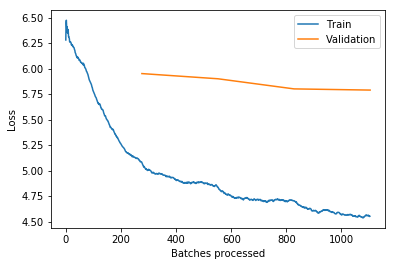

In [41]:
learn.recorder.plot_losses()

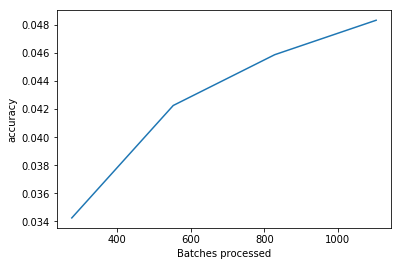

In [42]:
learn.recorder.plot_metrics()

In [43]:
#learn.recorder.plot_lr(show_moms=True)

In [44]:
learn.save('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_e004_20190714', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_e004_20190714.pth')

In [48]:
learn.load('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_e004_20190714');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


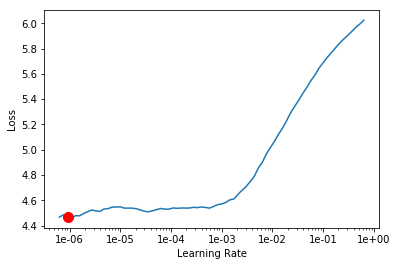

In [46]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
learn.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.577062,5.759785,0.048591,03:32
1,4.633544,5.749745,0.051047,03:32
2,4.598930,5.852021,0.045231,03:32
3,4.510996,5.844643,0.052468,03:32
4,4.444584,5.674518,0.058155,03:32
5,4.300500,5.634647,0.061644,03:32
6,4.247642,5.645650,0.058542,03:32
7,4.194890,5.641526,0.060352,03:32


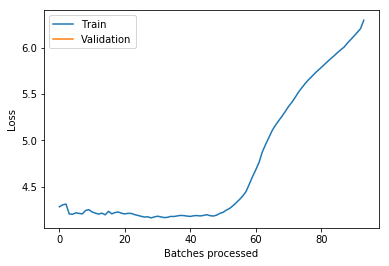

In [60]:
learn.recorder.plot_losses()

In [61]:
learn.recorder.plot_metrics()

AssertionError: There are no metrics to plot.

In [ ]:
learn.save('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_e012_20190714', return_path=True)

In [62]:
learn.load('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_e012_20190714');

In [63]:
# turn on MixUp!
learn = learn.mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 8.32E-05


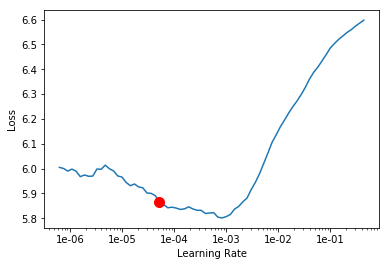

In [64]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [65]:
learn.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,5.590467,5.867373,0.052081,03:32
1,5.511134,5.793167,0.051564,03:32
2,5.476029,5.941154,0.044456,03:32
3,5.398797,5.698308,0.056733,03:32
4,5.323098,5.521061,0.067459,03:33
5,5.300508,5.568830,0.061385,03:32
6,5.209948,5.500532,0.065004,03:33
7,5.197344,5.524304,0.062678,03:33


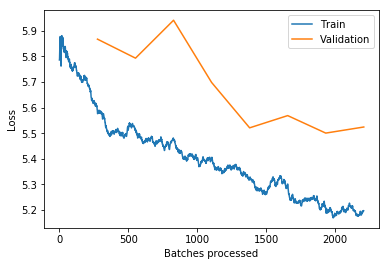

In [66]:
learn.recorder.plot_losses()

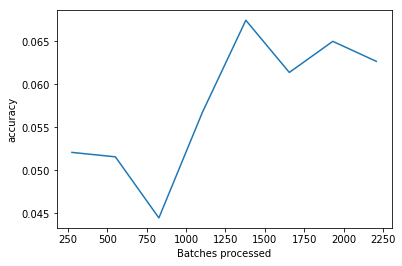

In [67]:
learn.recorder.plot_metrics()

In [68]:
learn.save('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e020_20190714', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e020_20190714.pth')

In [29]:
learn.load('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e020_20190714');

In [30]:
# turn on MixUp!
learn = learn.mixup()

In [31]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss',patience=4)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e020-140_20190714_best')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 9.12E-08


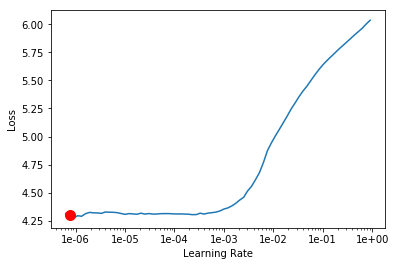

In [30]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit(120, lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,5.370513,5.501910,0.067718,03:33
1,5.298993,5.601264,0.060481,03:33
2,5.271125,5.540419,0.066296,03:32
3,5.248528,5.620379,0.062807,03:32
4,5.248924,5.517380,0.072241,03:32
5,5.193017,5.587467,0.066555,03:33
6,5.223988,5.545722,0.067847,03:33
7,5.138521,5.425531,0.068881,03:33
8,5.118874,5.479054,0.069915,03:32
9,5.089223,5.460766,0.073146,03:33


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



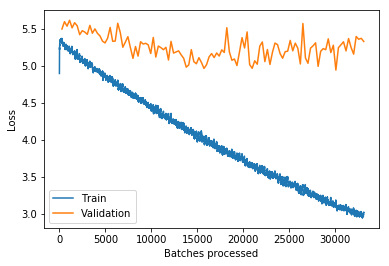

In [37]:
learn.recorder.plot_losses()

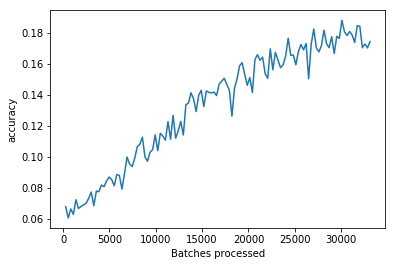

In [38]:
learn.recorder.plot_metrics()

In [39]:
learn.save('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e140_20190714', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e140_20190714.pth')

In [28]:
learn.load('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e140_20190714');

In [29]:
# turn on MixUp!
#learn = learn.mixup()

In [34]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss',patience=4)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e144_20190715_best')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-07


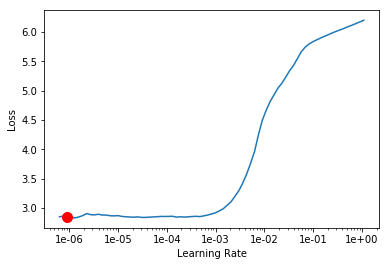

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit(150, lr=1e-4, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,2.996304,5.209391,0.178599,03:30
1,2.994376,5.200965,0.183898,03:32
2,2.953779,5.125305,0.178987,03:32
3,2.953355,5.341393,0.174464,03:32
4,2.928727,5.261428,0.180667,03:32
5,2.932275,5.300605,0.181442,03:33
6,2.929322,5.231597,0.191522,03:33
7,2.882204,5.329868,0.174722,03:32
8,2.667907,4.916903,0.210520,03:32
9,2.709180,4.936198,0.209356,03:33


Better model found at epoch 0 with accuracy value: 0.17859911918640137.
Better model found at epoch 1 with accuracy value: 0.18389764428138733.
Better model found at epoch 6 with accuracy value: 0.19152237474918365.
Epoch 7: reducing lr to 2e-05
Better model found at epoch 8 with accuracy value: 0.21051950752735138.
Better model found at epoch 10 with accuracy value: 0.2109072059392929.
Epoch 15: reducing lr to 4.000000000000001e-06
Better model found at epoch 17 with accuracy value: 0.21155337989330292.
Epoch 20: reducing lr to 8.000000000000002e-07
Better model found at epoch 21 with accuracy value: 0.2138795554637909.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 53: reducing lr to 5.1200000000000034e-11


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



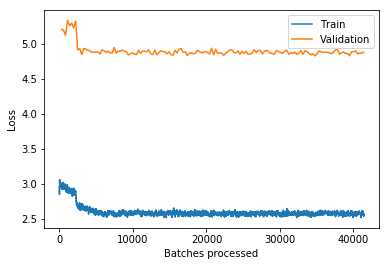

In [40]:
learn.recorder.plot_losses()

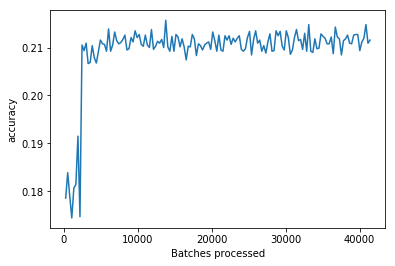

In [41]:
learn.recorder.plot_metrics()

In [42]:
learn.save('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e290_20190715', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e290_20190715.pth')

In [117]:
learn.load('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e290_20190715');

### 512px extended tfms+CA FP16 mixup

In [29]:
learn.load('xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e140-290_20190715_best');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 3.98E-05


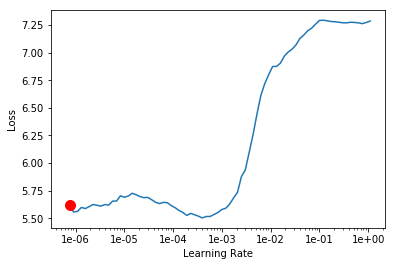

In [30]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [31]:
learn.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.201975,6.332438,0.095373,12:16
1,3.942757,5.732289,0.129749,12:19
2,3.657541,5.454453,0.158956,12:19
3,3.397210,5.157881,0.182476,12:18


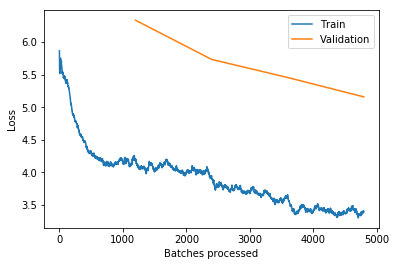

In [32]:
learn.recorder.plot_losses()

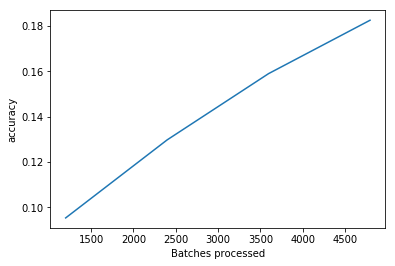

In [33]:
learn.recorder.plot_metrics()

In [43]:
#learn.recorder.plot_lr(show_moms=True)

In [35]:
learn.save('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e004_20190716', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e004_20190716.pth')

In [35]:
learn.load('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e004_20190716');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.91E-05


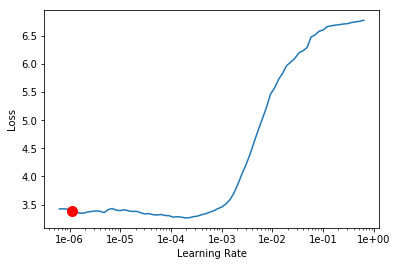

In [37]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [36]:
learn.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.538457,5.294007,0.170199,12:15
1,3.816161,6.447880,0.116826,12:17
2,3.752372,5.964454,0.132980,12:17
3,3.672850,5.520125,0.155983,12:17
4,3.438803,5.410517,0.173430,12:18
5,3.336414,5.122333,0.201732,12:18
6,3.157647,5.099802,0.200310,12:18
7,3.017508,4.938988,0.209098,12:18


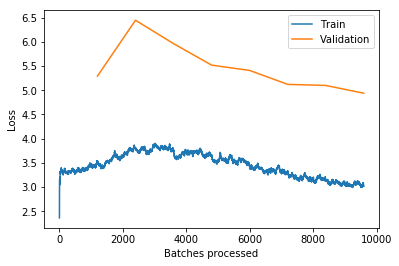

In [37]:
learn.recorder.plot_losses()

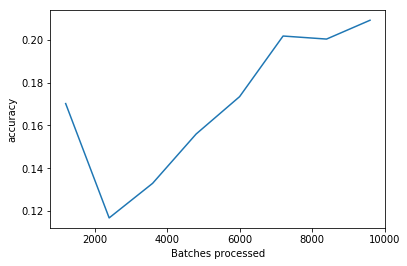

In [38]:
learn.recorder.plot_metrics()

In [39]:
learn.save('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e012_20190716', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e012_20190716.pth')

In [40]:
learn.load('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e012_20190716');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.58E-05


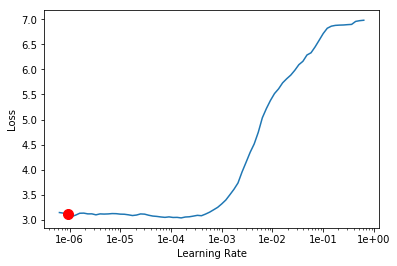

In [41]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [42]:
learn.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.242567,5.341661,0.177824,12:18
1,3.558829,5.810188,0.148359,12:18
2,3.560035,5.619701,0.158180,12:18
3,3.466934,5.711030,0.167614,12:19
4,3.330957,5.710030,0.181830,12:18
5,3.199524,5.335070,0.206513,12:19
6,2.997841,5.038083,0.220470,12:19
7,2.916281,5.028758,0.221763,12:19


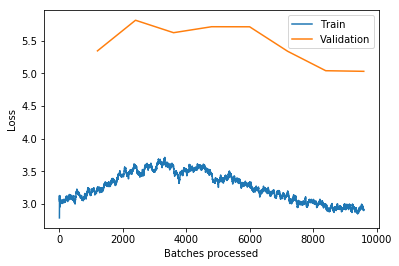

In [43]:
learn.recorder.plot_losses()

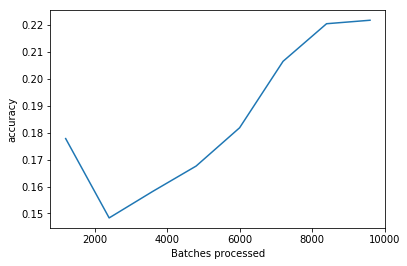

In [44]:
learn.recorder.plot_metrics()

In [45]:
learn.save('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e020_20190716', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e020_20190716.pth')

In [46]:
learn.load('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e020_20190716');

In [47]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss',patience=4)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e020-140_20190716_best')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 2.29E-05


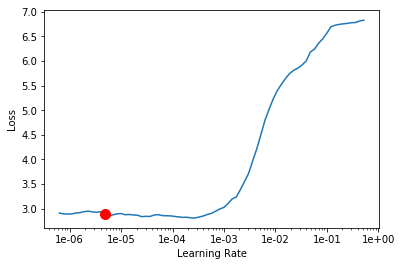

In [48]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
learn.fit(120, lr=1e-4, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,3.517333,5.779845,0.164125,12:18
1,3.530398,6.267509,0.144999,12:19
2,3.445457,5.909124,0.162445,12:19
3,3.441005,5.967928,0.178987,12:18
4,3.359536,5.567207,0.183122,12:19
5,3.431926,5.571079,0.175756,12:19
6,3.381206,5.332688,0.194753,12:19
7,3.280640,5.322150,0.180796,12:18
8,3.334568,5.945006,0.177307,12:19
9,3.288889,5.387107,0.190489,12:19


Better model found at epoch 0 with accuracy value: 0.16412509977817535.
Better model found at epoch 3 with accuracy value: 0.1789868175983429.
Better model found at epoch 4 with accuracy value: 0.18312224745750427.
Better model found at epoch 6 with accuracy value: 0.19475317001342773.
Epoch 12: reducing lr to 2e-05
Better model found at epoch 13 with accuracy value: 0.22344274818897247.
Better model found at epoch 14 with accuracy value: 0.22874127328395844.
Better model found at epoch 15 with accuracy value: 0.23210132122039795.
Better model found at epoch 16 with accuracy value: 0.23843370378017426.
Better model found at epoch 19 with accuracy value: 0.24386146664619446.
Epoch 28: reducing lr to 4.000000000000001e-06
Better model found at epoch 31 with accuracy value: 0.24411992728710175.
Better model found at epoch 33 with accuracy value: 0.2505815327167511.
Epoch 33: reducing lr to 8.000000000000002e-07
Better model found at epoch 37 with accuracy value: 0.2542000412940979.
Epoch 

Exception in thread Thread-117:
Traceback (most recent call last):
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 158, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 256, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/ho

KeyboardInterrupt: 

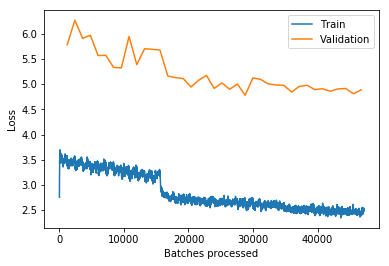

In [50]:
learn.recorder.plot_losses()

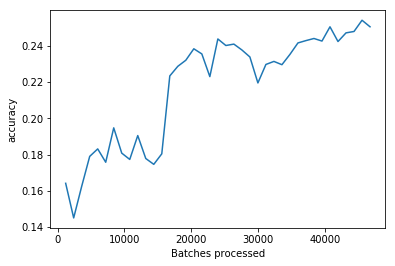

In [51]:
learn.recorder.plot_metrics()

In [52]:
learn.save('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e58_20190716', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e58_20190716.pth')

In [53]:
learn.load('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e58_20190716');

In [34]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss',patience=4)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e???_2019071?_best')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-07


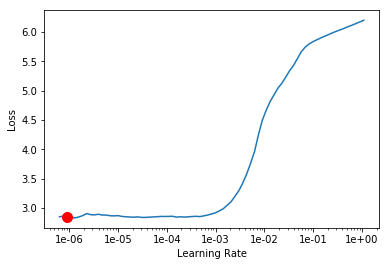

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit(150, lr=1e-4, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,2.996304,5.209391,0.178599,03:30
1,2.994376,5.200965,0.183898,03:32
2,2.953779,5.125305,0.178987,03:32
3,2.953355,5.341393,0.174464,03:32
4,2.928727,5.261428,0.180667,03:32
5,2.932275,5.300605,0.181442,03:33
6,2.929322,5.231597,0.191522,03:33
7,2.882204,5.329868,0.174722,03:32
8,2.667907,4.916903,0.210520,03:32
9,2.709180,4.936198,0.209356,03:33


Better model found at epoch 0 with accuracy value: 0.17859911918640137.
Better model found at epoch 1 with accuracy value: 0.18389764428138733.
Better model found at epoch 6 with accuracy value: 0.19152237474918365.
Epoch 7: reducing lr to 2e-05
Better model found at epoch 8 with accuracy value: 0.21051950752735138.
Better model found at epoch 10 with accuracy value: 0.2109072059392929.
Epoch 15: reducing lr to 4.000000000000001e-06
Better model found at epoch 17 with accuracy value: 0.21155337989330292.
Epoch 20: reducing lr to 8.000000000000002e-07
Better model found at epoch 21 with accuracy value: 0.2138795554637909.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 53: reducing lr to 5.1200000000000034e-11


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



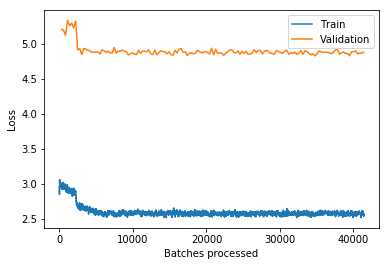

In [40]:
learn.recorder.plot_losses()

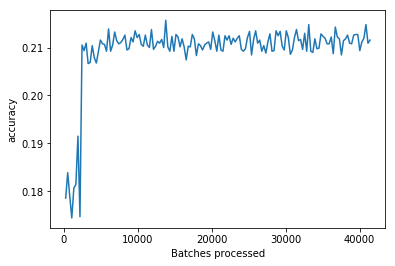

In [41]:
learn.recorder.plot_metrics()

In [42]:
learn.save('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e290_2019071?', return_path=True)

PosixPath('train/models/xresnet50c_valid-split-ex-v1_256px_tfms_ca_fp16_mu_e290_20190715.pth')

In [43]:
learn.load('xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e290_2019071?');

## Training AdvXResNet50

In [32]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [33]:
# based on the accuracy function but only use the first 1108 outputs
def accuracy_label(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input[:,:1108].argmax(dim=-1).view(n,-1)
    #targs = targs.view(n,-1)
    targs = targs[:,:1108].argmax(dim=-1).view(n,-1) # VERY LIKELY NEEDED!
    return (input==targs).float().mean()

# based on the accuracy function but only uses 1108: outputs
def accuracy_domain(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input[:,1108:].argmax(dim=-1).view(n,-1)
    #targs = targs.view(n,-1)
    targs = targs[:,1108:].argmax(dim=-1).view(n,-1) # VERY LIKELY NEEDED!
    return (input==targs).float().mean()

In [34]:
# functions to return losses as metrics?
#def loss_1():
#    return mean(learn_a.loss_func.losses_a)
#
#def loss_2():
#    return mean(learn_a.loss_func.losses_b)

In [35]:
class OneCycleGRScheduler(LearnerCallback):
    # pct_start:float=0.3
    def __init__(self, learn:Learner, gr_max:float=1.0, div_factor:float=25., pct_start:float=0.75,
                 final_div:float=None, tot_epochs:int=None, start_epoch:int=None):
        super().__init__(learn)
        self.gr_max,self.div_factor,self.pct_start,self.final_div = gr_max,div_factor,pct_start,final_div
        if self.final_div is None: self.final_div = div_factor*1e4
        if is_listy(self.gr_max): self.gr_max = np.array(self.gr_max)
        self.start_epoch, self.tot_epochs = start_epoch, tot_epochs

    def steps(self, *steps_cfg:StartOptEnd):
        "Build anneal schedule for all of the parameters."
        return [Scheduler(step, n_iter, func=func)
                for (step,(n_iter,func)) in zip(steps_cfg, self.phases)]

    def on_train_begin(self, n_epochs:int, epoch:int, **kwargs:Any)->None:
        "Initialize our optimization params based on our annealing schedule."
        #res = {'epoch':self.start_epoch} if self.start_epoch is not None else None
        self.start_epoch = ifnone(self.start_epoch, epoch)
        self.tot_epochs = ifnone(self.tot_epochs, n_epochs)
        n = len(self.learn.data.train_dl) * self.tot_epochs
        a1 = int(n * self.pct_start)
        a2 = n-a1
        self.phases = ((a1, annealing_cos), (a2, annealing_no)) # CHANGE HERE FOR FUNCTION! annealing_cos, annealing_linear
        low_gr = self.gr_max/self.div_factor
        self.gr_scheds = self.steps((low_gr, self.gr_max), (self.gr_max, self.gr_max/self.final_div))
        self.opt = self.learn.opt
        self.opt.gr = self.gr_scheds[0].start
        self.idx_s = 0
        self.opt.grs = []
        #return res
    
    def jump_to_epoch(self, epoch:int)->None:
        for _ in range(len(self.learn.data.train_dl) * epoch):
            self.on_batch_end(True)

    def on_batch_end(self, train, **kwargs:Any)->None:
        "Take one step forward on the annealing schedule for the optim params."
        if train:
            #if self.idx_s >= len(self.gr_scheds): return {'stop_training': True, 'stop_epoch': True}
            self.opt.gr = -self.gr_scheds[self.idx_s].step()
            self.opt.grs.append(self.opt.gr)
            # when the current schedule is complete we move onto the next
            # schedule. (in 1-cycle there are two schedules)
            if self.gr_scheds[self.idx_s].is_done:
                self.idx_s += 1

    #def on_epoch_end(self, epoch, **kwargs:Any)->None:
    #    "Tell Learner to stop if the cycle is finished."
    #    if epoch > self.tot_epochs: return {'stop_training': True}

In [36]:
learn_a = Learner(data_a, advxresnet50c, metrics=[accuracy_label, accuracy_domain], callback_fns=[CSVLogger])#, OneCycleGRScheduler])


In [37]:
#learn_a.summary()

In [38]:
#redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss',patience = 2)
#savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', name='rcic_multicat_v6_resnet34_baseline_randomshuffle_best_512')


In [39]:
#learn_a.summary()

In [40]:
# VERSION 2: With CE for targets and BCE for adversarial targets.
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b.view(-1), target_b.view(-1), **kwargs) # for BCEWithLogitsLoss input and target needs to flattend
        return loss_a + loss_b

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target[:,:1108].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = BCEWithLogitsLoss
        input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        target_b = target[:,1108:].float().transpose(self.axis,-1).contiguous() # argmax needed to get the class
        ## testing func_a
        #input_b = torch.tensor([0.])
        #target_b = torch.tensor([0.])
        
        
        # not needed?
        #if self.floatify: target = target.float()
        #input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        
        #loss_a = self.func_a.__call__(input_a, target_a.view(-1), **kwargs) # get ird of .view(-1) ???
        #loss_b = self.func_b.__call__(input_b, target_b.view(-1), **kwargs)
        #return loss_a + loss_b
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [41]:
# VERSION 3: With CE for targets and CE for adversarial targets.
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)
        self.losses_a, self.losses_b = [], []

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b, target_b, **kwargs)
        
        #if train: # does not work? where is train set/located?
        self.losses_a.append(loss_a.item())
        self.losses_b.append(loss_b.item())
        
        return loss_a + loss_b

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target[:,:1108].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = CrossEntropyLoss
        input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        target_b = target[:,1108:].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = BCEWithLogitsLoss
        #input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        #target_b = target[:,1108:].float().transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        ## func_b = 0 --> testing func_a
        #input_b = torch.tensor([0.])
        #target_b = torch.tensor([0.])
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [42]:
learn_a.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [43]:
#CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.BCEWithLogitsLoss)
CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.CrossEntropyLoss)

In [44]:
learn_a.loss_func = CombinedLoss

In [45]:
learn_a.loss_func

CombinedFlattenedLoss of CrossEntropyLoss() and CrossEntropyLoss()

In [46]:
learn_a.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 fastai.callbacks.csv_logger.CSVLogger]

### Training with tfms and full dataset

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 2.75E-03


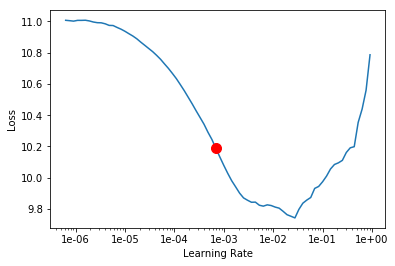

In [47]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [47]:
learn_a.fit_one_cycle(10, max_lr=1e-3)#, callbacks=[OneCycleGRScheduler])

epoch,train_loss,valid_loss,accuracy_label,accuracy_domain,time
0,8.307154,18.222664,0.001805,0.000000,02:42
1,7.669796,18.029703,0.001805,0.000000,02:41
2,7.251522,13.961251,0.002708,0.000000,02:41
3,6.843869,16.599556,0.001805,0.000000,02:41
4,6.466746,13.494913,0.002708,0.008123,02:41
5,6.043951,20.058886,0.002106,0.000000,02:40
6,5.623658,20.725157,0.001805,0.000000,02:41
7,5.209484,21.375599,0.003008,0.000000,02:40
8,4.857718,23.020866,0.002407,0.000000,02:41
9,4.656760,23.064049,0.002407,0.000000,02:41


In [48]:
10*(86+9), len(learn_a.loss_func.losses_a), len(learn_a.loss_func.losses_b)#, len(learn_a.opt.grs)

(950, 1000, 1000)

In [49]:
10*(86*2+18)

1900

In [50]:
#learn_a.loss_func.losses_a
#learn_a.loss_func.losses_b

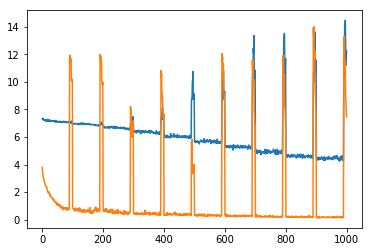

In [51]:
f, ax = plt.subplots()
#plt.plot(learn_a.opt.grs)
plt.plot(learn_a.loss_func.losses_a)
plt.plot(learn_a.loss_func.losses_b)
#ax.set_ylim(0,12)

In [52]:
#plt.plot(learn_a.opt.grs)

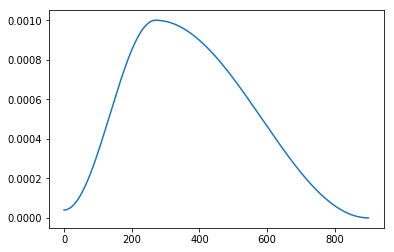

In [53]:
plt.plot(learn_a.recorder.lrs)

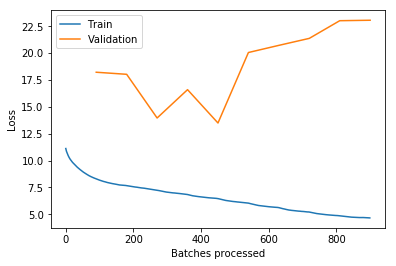

In [54]:
learn_a.recorder.plot_losses()

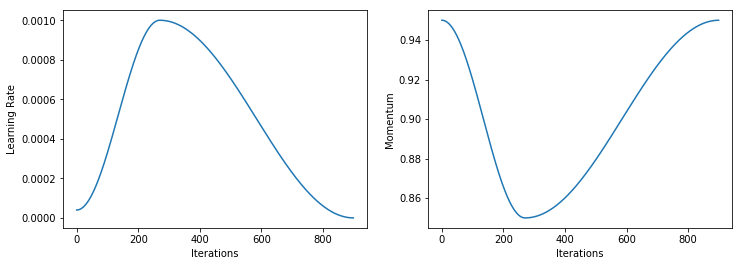

In [55]:
learn_a.recorder.plot_lr(show_moms=True)

In [56]:
learn_a.save('advxresnet50c_96px_e010_no-gr_20190711', return_path=True)

PosixPath('train/models/advxresnet50c_96px_e010_no-gr_20190711.pth')

In [57]:
learn_a = Learner(data_a, advxresnet50c, metrics=[accuracy_label, accuracy_domain], callback_fns=[CSVLogger, OneCycleGRScheduler])


In [58]:
# VERSION 3: With CE for targets and CE for adversarial targets.
class CombinedFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func_a, func_b, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func_a, self.func_b, self.axis,self.floatify,self.is_2d = func_a(*args,**kwargs), func_b(*args,**kwargs), axis,floatify,is_2d
        functools.update_wrapper(self, self.func)
        self.losses_a, self.losses_b = [], []

    def __repr__(self): return f"CombinedFlattenedLoss of {self.func_a} and {self.func_b}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v
        
    def func(self, input_a, target_a, input_b, target_b, **kwargs):
        loss_a = self.func_a.__call__(input_a, target_a, **kwargs) # getting rid of .view(-1) Ok ??? Could use .view(-1,input.shape[-1]) (from self.is_2d)
        loss_b = self.func_b.__call__(input_b, target_b, **kwargs)
        
        #if train: # does not work? where is train set/located?
        self.losses_a.append(loss_a.item())
        self.losses_b.append(loss_b.item())
        
        return loss_a + loss_b

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        
        # func_a = CrossEntropyLoss
        input_a = input[:,:1108].transpose(self.axis,-1).contiguous()
        target_a = target[:,:1108].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = CrossEntropyLoss
        input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        target_b = target[:,1108:].argmax(dim=-1).transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        # func_b = BCEWithLogitsLoss
        #input_b = input[:,1108:].transpose(self.axis,-1).contiguous()
        #target_b = target[:,1108:].float().transpose(self.axis,-1).contiguous() # argmax needed to get the class
        
        ## func_b = 0 --> testing func_a
        #input_b = torch.tensor([0.])
        #target_b = torch.tensor([0.])
        
        return self.func.__call__(input_a, target_a, input_b, target_b, **kwargs)

In [59]:
#CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.BCEWithLogitsLoss)
CombinedLoss = CombinedFlattenedLoss(nn.CrossEntropyLoss, nn.CrossEntropyLoss)

In [60]:
learn_a.loss_func = CombinedLoss

In [61]:
learn_a.loss_func

CombinedFlattenedLoss of CrossEntropyLoss() and CrossEntropyLoss()

In [62]:
learn_a.load('advxresnet50c_96px_e010_no-gr_20190711');

/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RevGrad. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type AdvXResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type output_a. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.58E-07


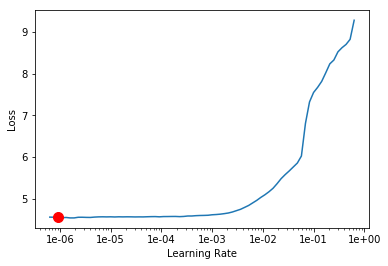

In [48]:
learn_a.lr_find()
learn_a.recorder.plot(suggestion=True)

In [63]:
learn_a.fit_one_cycle(10, max_lr=1e-4)#, callbacks=OneCycleGRScheduler)

epoch,train_loss,valid_loss,accuracy_label,accuracy_domain,time
0,4.597081,23.501469,0.002407,0.000000,02:41
1,4.602214,23.816214,0.002407,0.000000,02:41
2,4.613003,23.194736,0.003309,0.000000,02:41
3,4.560652,23.768064,0.003309,0.000000,02:41
4,4.472379,25.235840,0.002708,0.000000,02:41
5,4.378199,25.882395,0.003610,0.000000,02:41
6,4.287924,24.905573,0.003309,0.000000,02:41
7,4.215637,25.154118,0.003008,0.000000,02:41
8,4.170769,25.130878,0.003008,0.000000,02:41
9,4.151737,25.429380,0.002708,0.000000,02:41


In [64]:
86+9, len(learn_a.loss_func.losses_a), len(learn_a.loss_func.losses_b), len(learn_a.opt.grs)

(95, 1000, 1000, 900)

In [65]:
#learn_a.loss_func.losses_a
#learn_a.loss_func.losses_b

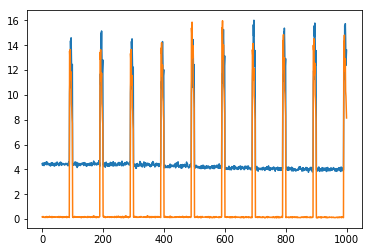

In [66]:
f, ax = plt.subplots()
#plt.plot(learn_a.opt.grs)
plt.plot(learn_a.loss_func.losses_a)
plt.plot(learn_a.loss_func.losses_b)
#ax.set_ylim(0,12)

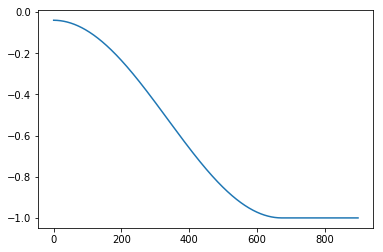

In [67]:
plt.plot(learn_a.opt.grs)

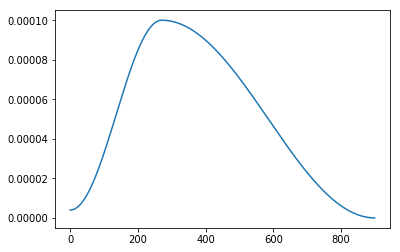

In [68]:
plt.plot(learn_a.recorder.lrs)

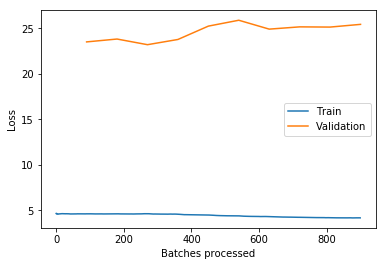

In [69]:
learn_a.recorder.plot_losses()

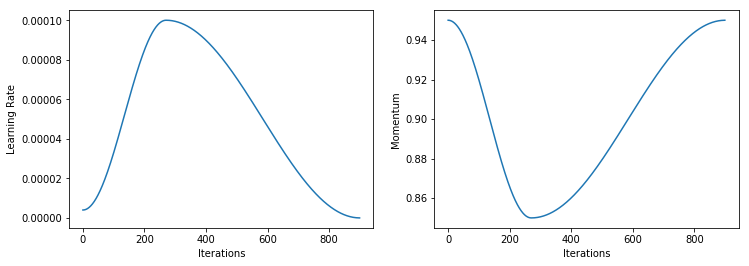

In [70]:
learn_a.recorder.plot_lr(show_moms=True)

In [71]:
learn_a.save('advxresnet50c_96px_e010gr_e10no-gr_20190711', return_path=True)

PosixPath('train/models/advxresnet50c_96px_e010gr_e10no-gr_20190711.pth')

In [72]:
learn_a.load('advxresnet50c_96px_e010gr_e10no-gr_20190711');

# Submission

## Get predicitions

In [54]:
model = 'xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e020-140_20190716_best'

In [55]:
learn.load(model)

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: EmptyLabelList
,,,,
Path: train, model=XResNet(
  (0): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, e

In [56]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [71]:
# get TTA prediction of test dataset
learn.to_fp32();

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: EmptyLabelList
,,,,
Path: train, model=XResNet(
  (0): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, e

In [72]:
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [78]:
# check length
len(preds)

19897

In [58]:
#preds

In [79]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [80]:
# get the names
preds_names = learn.data.test_ds.x.items

In [81]:
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]
# including sX
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [82]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [83]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,18
1,HEPG2-08_1_B04,69
2,HEPG2-08_1_B05,324
3,HEPG2-08_1_B06,69
4,HEPG2-08_1_B07,222


In [84]:
df_preds.to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [85]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 81.4k/81.4k [00:06<00:00, 13.3kB/s]
Successfully submitted to Recursion Cellular Image Classification

## Sample submission

In [77]:
sample = pd.read_csv('sub/sample_submission.csv')

In [78]:
sample.shape

(19897, 2)

In [79]:
sample.head()

,id_code,sirna
0,HEPG2-08_1_B03,911
1,HEPG2-08_1_B04,911
2,HEPG2-08_1_B05,911
3,HEPG2-08_1_B06,911
4,HEPG2-08_1_B07,911


## Join submission with sample submission

In [81]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [82]:
df_preds.shape

(19897, 2)

In [83]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,50
1,HEPG2-08_1_B04,69
2,HEPG2-08_1_B05,672
3,HEPG2-08_1_B06,69
4,HEPG2-08_1_B07,960


In [84]:
submission = pd.concat([sample['id_code'], df_preds], axis=1, sort=False)

In [85]:
submission.iloc[:,[0,-1]].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [86]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 70.3k/70.3k [00:07<00:00, 10.2kB/s]
Successfully submitted to Recursion Cellular Image Classification

In [ ]:
# WORKED FOR HIGHEST SCORE!

In [101]:
submission.iloc[:,[0,-1]].to_csv('results_test_20190716.csv', index=False)

In [102]:
!kaggle competitions submit -c recursion-cellular-image-classification -f results_test_20190716.csv -m "results_test_20190716"

100%|████████████████████████████████████████| 358k/358k [00:05<00:00, 61.5kB/s]
Successfully submitted to Recursion Cellular Image Classification

# Others

## Callback

In [ ]:
# https://docs.fast.ai/callback.html#callback

In [ ]:
# https://docs.fast.ai/callbacks.general_sched.html
def grl_scheduling(learn, n_cycles):
    '''Gradient reversal layer scheduling'''
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n).schedule_hp('grl_factor', grl, anneal=annealing_cos))
              for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    #learn. ??
    
    #if cycle_mult != 1:
    #    total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    #else: total_epochs = n_cycles * cycle_len
    #learn.fit(total_epochs)

In [ ]:
# https://docs.fast.ai/callback.html#OptimWrapper
# OptimWrapper needed with the 'grl' parameter?

In [ ]:
# Einfacher Callback mit nur 'on_train_begin'???

# Oder besser (?): monkey-patch optimizer mit 'grl' Variable
# und dann Adaptierung der 'grl_scheduling' Funktion!